## Mapping of cattle herd at high spatial resolution based on dasimetric mapping

Dasymetric mapping is a geospatial technique that uses information such as **land cover types** to more accurately distribute data that have been assigned to **selected boundaries like census blocks**. Adapted from ***Intelligent Dasymetric Mapping (IDM) Toolbox*** for ArcGIS, avaliable at: https://www.epa.gov/enviroatlas/dasymetric-toolbox

## Authenticate Google Earth Engine

In [26]:
import ee
ee.Authenticate()
ee.Initialize()

Enter verification code:  4/1AX4XfWhhT-lOCO_b_x3uNBJUaMyF1S-aXVzhJrYoq-xN9-sx0ZTdvP_r8Zs



Successfully saved authorization token.


## Import libraries

In [27]:
import folium
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from ipygee import*
from pandas.plotting import register_matplotlib_converters
import geemap
import geemap.chart as chart

EE_TILES = 'https://earthengine.googleapis.com/map/{mapid}/{{z}}/{{x}}/{{y}}?token={token}'

print('Folium version: ' + folium.__version__)

def Mapdisplay(center, dicc, Tiles="OpensTreetMap",zoom_start=10):
    '''
    :param center: Center of the map (Latitude and Longitude).
    :param dicc: Earth Engine Geometries or Tiles dictionary
    :param Tiles: Mapbox Bright,Mapbox Control Room,Stamen Terrain,Stamen Toner,stamenwatercolor,cartodbpositron.
    :zoom_start: Initial zoom level for the map.
    :return: A folium.Map object.
    '''
    mapViz = folium.Map(location=center,tiles=Tiles, zoom_start=zoom_start)
    for k,v in dicc.items():
      if ee.image.Image in [type(x) for x in v.values()]:
        folium.TileLayer(
            tiles = v["tile_fetcher"].url_format,
            attr  = 'Google Earth Engine',
            overlay =True,
            name  = k
          ).add_to(mapViz)
      else:
        folium.GeoJson(
        data = v,
        name = k
          ).add_to(mapViz)
    mapViz.add_child(folium.LayerControl())
    return mapViz

Folium version: 0.12.1


## Load boundaries used to map the herd

In [28]:
district = ee.FeatureCollection('users/opereira/trase/south_america/paraguay/borders/paraguay_2019_distritos')\
.filter(ee.Filter.inList('dpto', ['17', '16', '15']))\
.select(['dist_desc',	'distrito'])

senacsa = ee.FeatureCollection('users/opereira/trase/south_america/paraguay/borders/SENACSA_sanitary_sectors')\
.filter(ee.Filter.inList('DEPARTAMEN', ['ALTO PARAGUAY', 'BOQUERON', 'PRESIDENTE HAYES']))\
.select(['CODDIST',	'DISTRITO'])
senacsa1 = ee.Image().toByte().paint(senacsa, 3, 5);
district1 = ee.Image().toByte().paint(district, 2, 4);

visParams_sena = {'palette': '0000FF',
    'max': 3,
    'opacity': 0.5
};

visParams_disc = {'palette': '000000',
    'max': 3,
    'opacity': 0.5
};

senacsa_tk = senacsa1.getMapId(visParams_sena)
disct_tk = district1.getMapId(visParams_disc)

center = [-22.266659, -59.816228]
Mapdisplay(center,{'SENACSA':senacsa_tk, 'Official': disct_tk},zoom_start=8)

## Join tables: feature collections with herd tables

In [29]:
herd = ee.FeatureCollection("users/opereira/trase/south_america/paraguay/borders/Cattle_Herd_Origin_2014_2019")

filtro = ee.Filter.equals(
              leftField='CODDIST',
              rightField='COD_DTO', 
            );

saveAllJoin = ee.Join.saveAll(
              matchesKey='District_Code',
              ordering='COD_DTO',
              ascending= True
            );

Dat = saveAllJoin.apply(senacsa, herd, filtro);

def joining(feature): 
    popu_19 = ee.Feature(ee.List(feature.get('District_Code')).get(0)).get('Total');
    final = feature.set('Herd_2019', popu_19);
    return final;
bgfips1 = Dat.map(joining)

pop10 = ee.Image.random().multiply(100000).toInt32()\
.clip(district)\
.reproject(crs=senacsa1.projection().crs(),  scale=2000);

pop10_1 = pop10.reduceToVectors(
          geometry=district,
          crs=senacsa1.projection(),
          scale=2000,
          geometryType='polygon',
          eightConnected=False,
          labelProperty='ZONE_ID',
          );

## Dependent variable: Prepare pasture area data and calculate proportional distribution

In [30]:
MB = ee.Image('projects/mapbiomas-chaco/public/collection2/mapbiomas_chaco_collection2_integration_v1');

collection_2019 = MB.toUint8().clip(district).select('classification_2019').toUint8().clip(district);

def grouping(img):
    pasto=img.eq(15).add(img.eq(6)).add(img.eq(11)).add(img.eq(42)).add(img.eq(43)).add(img.eq(44))
    return pasto.remap([0, 1], [0, 1]);

LULC_2019_0 = grouping(collection_2019).clip(district);

LULC_2019 = LULC_2018_0.updateMask(LULC_2019_0.gt(0)).clip(district);

prop = LULC_2019.clip(district).reduceRegions(
  collection=pop10_1,
  reducer=ee.Reducer.sum(),
  scale=30,
);

denstity_0 = prop.filter(ee.Filter.notNull(['sum']))\
.reduceToImage(
    properties=['sum'],
    reducer=ee.Reducer.mean()
   );

mini = denstity_0.reduceRegion(
    reducer=ee.Reducer.min(),
    geometry=district,
    scale=100,
    maxPixels=1e13,
    bestEffort=True
   ).get('mean');

maxi = denstity_0.reduceRegion(
    reducer=ee.Reducer.max(),
    geometry=district,
    scale=100,
    maxPixels=1e13,
    bestEffort=True
    ).get('mean');

density = denstity_0.unitScale(ee.Number(mini), ee.Number(maxi)).multiply(100);

relative_density = ee.Image(1)\
          .where(density.lt(1), 0)\
          .where(density.gte(1).And(density.lte(5)), 1)\
          .where(density.gte(6).And(density.lte(10)), 2)\
          .where(density.gte(11).And(density.lte(17)), 3)\
          .where(density.gte(18).And(density.lte(23)), 5)\
          .where(density.gte(24).And(density.lte(34)), 8)\
          .where(density.gte(35).And(density.lte(50)), 12)\
          .where(density.gte(51).And(density.lte(75)), 16)\
          .where(density.gte(76).And(density.lte(90)), 20)\
          .where(density.gte(91).And(density.lte(100)), 25)\
          .clip(district).reproject(crs=senacsa1.projection().crs(),  scale=2000).toUint8();

visParams_rdensity = {'palette': ['blue', 'green', 'yellow', 'orange', 'red'],
    'min': 0,
    'max': 25,
    'opacity': 0.9
};

rdensity_tk = relative_density.getMapId(visParams_rdensity)

center = [-22.266659, -59.816228]
Mapdisplay(center,{'SENACSA':rdensity_tk},zoom_start=7)

## Dasymetric mapping

### Calculate total population per census block (raster) and expected proportion of each raster cell

In [32]:
bgfips = bgfips1.filter(ee.Filter.notNull(['sum'])).reduceToImage(
    properties=['CODDIST'],
    reducer=ee.Reducer.first()
    ).reproject(crs=senacsa1.projection().crs(),  scale=2000).toUint16().clip(district)

densities = ['area0','area1','area2','area3', 'area4', 'area5', 'area6', 'area7', 'area8', 'area9']
count = relative_density.eq([0, 1, 2, 3, 5, 8, 12, 16, 20, 25]).rename(densities);
total = count.multiply(ee.Image.pixelArea().multiply(0.0001));
lctab0 = total.reduceRegions(
      collection=senacsa,
      reducer=ee.Reducer.sum(),
      scale=2000,
      );
#lctab0.getInfo()

def computeTotal(feature):
                          P0=ee.Number(feature.get('area0'))
                          P1=ee.Number(feature.get('area1'))
                          P2=ee.Number(feature.get('area2'))
                          P3=ee.Number(feature.get('area3'))
                          P4=ee.Number(feature.get('area4'))
                          P5=ee.Number(feature.get('area5'))
                          P6=ee.Number(feature.get('area6'))
                          P7=ee.Number(feature.get('area7'))
                          P8=ee.Number(feature.get('area8'))
                          P9=ee.Number(feature.get('area9'))
                          return feature.set('Total', P0.add(P1).add(P2).add(P3).add(P4).add(P5).add(P6).add(P7).add(P8).add(P9));

total = lctab0.map(computeTotal);

def computeE(feature):
              P0 = ee.Number(feature.get('area0'))
              P1 = ee.Number(feature.get('area1'))
              P2 = ee.Number(feature.get('area2'))
              P3 = ee.Number(feature.get('area3'))
              P4 = ee.Number(feature.get('area4'))
              P5 = ee.Number(feature.get('area5'))
              P6 = ee.Number(feature.get('area6'))
              P7 = ee.Number(feature.get('area7'))
              P8 = ee.Number(feature.get('area8'))
              P9 = ee.Number(feature.get('area9'))
              Total = ee.Number(feature.get('Total'))
              return feature.set('E', P0.divide(Total).multiply(0)
              .add(P1.divide(Total).multiply(1))
              .add(P2.divide(Total).multiply(2))
              .add(P4.divide(Total).multiply(5))
              .add(P5.divide(Total).multiply(8))
              .add(P6.divide(Total).multiply(12))
              .add(P7.divide(Total).multiply(16))
              .add(P8.divide(Total).multiply(20))
              .add(P9.divide(Total).multiply(25)))

E_0 = total.map(computeE)

#E_0.getInfo()
#total.getInfo()

### Aplying dasimetric equation and viewing results

In [33]:
Total = E_0.reduceToImage(
        properties=['Total'],
        reducer=ee.Reducer.first()).reproject(crs=bgfips.projection().crs(),  scale=2000).clip(district).select([0], ['Total'])

E = E_0.reduceToImage(
        properties=['E'],
        reducer=ee.Reducer.first()).reproject(crs=bgfips.projection().crs(),  scale=2000).clip(district).select([0], ['E']);

Popu_90 = bgfips1.reduceToImage(
          properties=['Herd_2019'],
          reducer=ee.Reducer.first()).reproject(crs=bgfips.projection().crs(),  scale=2000).clip(district).select([0], ['Population']);

final = relative_density.select([0], ['Density']).addBands(Popu_90).addBands(E).addBands(Total);

dasymetric_herd = final.addBands(final.expression('rdensity * popu90 * 400 / (E * Total)', {
        'rdensity':final.select('Density'), 
        'popu90':final.select('Population'),  
        'E':final.select('E'), 
        'Total':final.select('Total')}).rename('Cattle_herd_19'));

visParams_final = {"palette":["afffe9","bfff6a","fcff49","ffd22d","ff3b1b"],
    'min': -10,
    'max': 420,
    'opacity': 1
};

final_tk = dasymetric_herd.select('Cattle_herd_19').getMapId(visParams_final)

center = [-22.266659, -59.816228]
Mapdisplay(center,{'Cattle herd 2019': final_tk, 'SENACSA limit':senacsa_tk, 'District limits': disct_tk},zoom_start=7)

### Validation: comparing modeled and measured herd

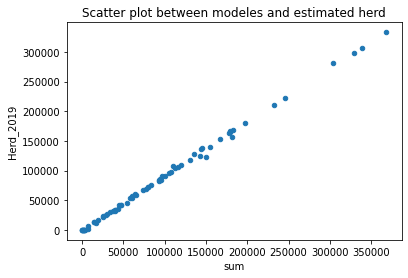

In [34]:
prop = dasymetric_herd.select('Cattle_herd_19').reduceRegions(
  collection=bgfips1,
  reducer=ee.Reducer.sum(),
  scale=2000,
);

Map = geemap.Map()

features = ee.FeatureCollection(prop) \
    .select(['sum', 'Herd_2019'])

df = geemap.ee_to_pandas(features)

dataFrame = pd.DataFrame(data=df, columns=['sum', 'Herd_2019']);

dataFrame.plot.scatter(x='sum', y='Herd_2019', title= "Scatter plot between modeles and estimated herd");

plot.show(block=True)